In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

bEdges = np.load('BandEdge.npy').item()
DefTot = np.load('DefectTotalEnergy.npy').item()
E0 = DefTot['default'][0]['0']
FreyCorr = np.load('FreysoldtCorrections.npy').item()
ChemPot = np.load('ChemicalReferences.npy').item()
text_def = np.load('LineLabels.npy').item()
colors = np.load('LineColors.npy').item()

In [2]:
def setChemPot(cond, delta={}):
    mu = {}
    mu['Zn'] = cond[0] + ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    mu['Ge'] = cond[1] + ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
    mu['N'] = cond[2] + ChemPot['N'][0]/ChemPot['N'][1]['N']
    for ref in ChemPot:
        if len(set(ChemPot[ref][1].keys()) - {'Zn', 'Ge', 'N'}) > 1: 
            continue
        if len(ChemPot[ref][1]) == 1:
            for ele in ChemPot[ref][1]:
                if not ele in ['Zn', 'Ge', 'N']:
                    if not ele in mu: 
                        mu[ele] = 0
                    mu[ele] = min(mu[ele], ChemPot[ref][0] / ChemPot[ref][1][ele])
        else:
            for ele in ChemPot[ref][1]:
                if not ele in ['Zn', 'Ge', 'N']:
                    if not ele in mu: 
                        mu[ele] = 0
                    mu[ele] = min(mu[ele], ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
    return mu

In [3]:
def getPOSCARdiff(defect):
    default = {'Zn':32, 'Ge':32, 'N':64}
    n_mu = {}
    for i in DefTot[defect][1]:
        if i in default:
            n_mu[i] = DefTot[defect][1][i] - default[i]
        else: 
            n_mu[i] = DefTot[defect][1][i]
    return n_mu

In [4]:
def getLine(defect, cond, BandEdges = bEdges, Ef = np.arange(0, bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB'],0.0001), charge = ''):
    chem = setChemPot(cond)
    defLoc = deepcopy(DefTot)
    defPar = defLoc[defect]
    n_mu = getPOSCARdiff(defect)
    levels = defPar[0]
    pLevels = {}
    #print levels
    #def_i_l = []
    
    if charge:
        if charge in FreyCorr[defect]:
            levels[charge] += FreyCorr[defect][charge]
        pLevels[charge] = defPar[0][charge] - E0 - sum(n_mu[j] * chem[j] for j in n_mu) + int(charge) * (Ef + BandEdges['ZnGeN2_VB'])
    else: 
        for i in levels:
            # add functionality to get defect levels: 
            # if str(int(i)-1) in levels:
            #    def_i_l += defPar[0][i] - defPar[0][str(int(i)-1)] - bEdges['VB']

            if i in FreyCorr[defect]:
                levels[i] += FreyCorr[defect][i]
            pLevels[i] = defPar[0][i] - E0 - sum(n_mu[j] * chem[j] for j in n_mu) + int(i) * (Ef + BandEdges['ZnGeN2_VB'])
    
    charges = [int(l) for l in pLevels]
    charges.sort()
    intlevels = {defect+' '+str(q)+'/'+str(q+1):round(pLevels[str(q)][0] - pLevels[str(q+1)][0],3) for q in charges[-len(charges):-1]}
    print intlevels
    pDefect = np.minimum.reduce([pLevels[i] for i in pLevels])
    #print (pDefect[0], pDefect[-1])
    return pDefect

In [5]:
from fractions import gcd
def FormEnth(Material):
    mat = ChemPot[Material]
    return (mat[0] - sum(ChemPot[ele][0]/ChemPot[ele][1][ele]* mat[1][ele] for ele in mat[1]))/reduce(gcd,[i for i in mat[1].values()])

In [6]:
Znpoor1 = [FormEnth('ZnGeN2') - FormEnth('Ge3N4')/2, 0, FormEnth('Ge3N4')/4]
Znpoor2 = [FormEnth('ZnGeN2') - FormEnth('Ge3N4')/3, FormEnth('Ge3N4')/3, 0]
Gepoor = [0, FormEnth('ZnGeN2'), 0]
Npoor = [0, 0, FormEnth('ZnGeN2')/2]

In [7]:
def contourdef(defect, Ncolors, charge='',add_mu={}):
    defLoc = DefTot[defect]
    n_mu = getPOSCARdiff(defect)
    muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    muGe0 = ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
    x = np.arange(-1.10, 0.0, 1e-2) 
    muZn = x + muZn0
    y = np.arange(-1.10, 0.0, 1e-2) 
    muGe = y + muGe0
    muZn, muGe = np.meshgrid(muZn, muGe)
    muN = (FormEnth('ZnGeN2') - muZn - muGe + muZn0 + muGe0)/2.0 + ChemPot['N'][0]/ChemPot['N'][1]['N']
    mu = {'Zn':muZn, 'Ge':muGe, 'N':muN}
    for i in add_mu:
        mu[i] = 0*muZn + add_mu[i]
    for i in mu:
        print mu[i][0][0]
    for ele in DefTot[defect][1]:
        print ele
        if ele not in mu:
            lrefs = {}
            lmu = {}
            for ref in ChemPot:
                if len(set(ChemPot[ref][1].keys()) - {'Zn', 'Ge', 'N'}) > 1: 
                    continue
                if ele in ChemPot[ref][1]:
                    lrefs[ref] = ref
                    lmu[ref] = np.array(0 * muZn + ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
            if len(lrefs) > 1:
                mumat3 = np.dstack((lmu[i] for i in lmu))
                mu[ele] = np.amin(mumat3, axis=2)
            else:
                mu[ele] = lmu.values()[0]
            
    print n_mu
    if not charge:
        a = sum(n_mu[j] * mu[j] for j in n_mu)
        z = DefTot[defect][0]['0'] - E0 - sum(n_mu[j] * mu[j] for j in n_mu)
        zmin = np.min([z[-1][1],z[-1,-1],z[14][108],z[40][0]])
        zmax = np.max([z[-1][1],z[-1,-1],z[14][108],z[40][0]])
    print zmin, zmax
    N2conv = muGe-muGe0 > (FormEnth('ZnGeN2')-muZn+ muZn0)
    Ge3N4conv = muGe-muGe0 < -2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - (muZn-muZn0))
    z = z * N2conv * Ge3N4conv + z[55][55]*(2-N2conv-Ge3N4conv-(1-N2conv)*(1-Ge3N4conv))
    print(z[55][55])
    fig, ax = plt.subplots()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.xlabel('$\Delta\mu_{Zn}$  (eV)', fontsize=18)
    plt.ylabel('$\Delta\mu_{Ge}$  (eV)', fontsize=18)
    ax.xaxis.labelpad = 15

    fig.tight_layout()

    cmap = plt.contourf(muZn - muZn0, muGe-muGe0, z, Ncolors)
    ax.fill_between(y, -2, FormEnth('ZnGeN2')-x, facecolor='#ffffff')
    ax.fill_between(y, 0, np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)), facecolor='#cc5555')
    ax.set_xlim([-1.095, -0.01])
    ax.set_ylim([-1.095, -0.01])
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.plot(y, FormEnth('ZnGeN2')-x,'k')
    plt.plot(y,np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)),'k')
    ax.text(-0.98,-0.1,u'Ge$_3$N$_4$',fontdict={'size':18},color='#000000')
    ax.text(-0.8,-0.8,u'$\Delta\mu_{N} > 0$',fontdict={'size':18},color='#000000')
    
    # Now adding the colorbar
    cbaxes = fig.add_axes([1.05, 0, 0.05, 0.8]) 
    cb = plt.colorbar(cmap, cax = cbaxes)  
    cb.ax.tick_params(labelsize=16)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))


    
    #plt.colorbar(cmap)
    plt.savefig('Savetemp.png', bbox_inches='tight', format='png', dpi=300)
    plt.show() 

-2.3719226
-6.450436785000001
-11.013023415
-9.670895155
Zn
Ge
N
{'Zn': 1, 'Ge': -1, 'N': 0}
3.7326437350000816 5.752643735000083
4.672643735000082


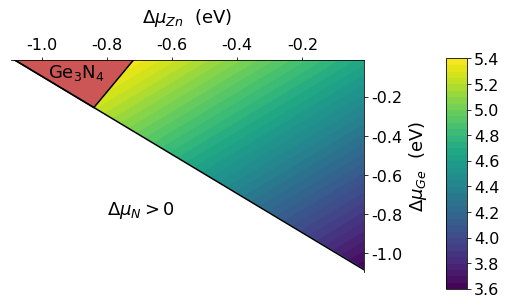

In [8]:
contourdef('Zn_Ge',40,add_mu={'O':ChemPot['O'][0]/2-4.0})
#contourdef('O_N',40)

-2.3719226
-6.450436785000001
-9.670895155
Zn
Ge
O
N
{'Zn': 0, 'Ge': 0, 'O': 1, 'N': -1}
2.1324757591667165 2.6902897850000507
2.22028978500005


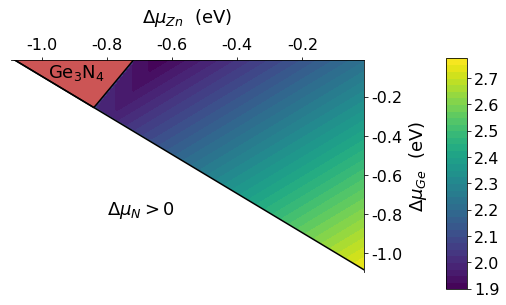

In [9]:
contourdef('O_N',40)

In [10]:
def contourdef2(defects, Ncolors, action='add', charge=[],add_mu={}):
    
    muZn0 = ChemPot['Zn'][0]/ChemPot['Zn'][1]['Zn']
    muGe0 = ChemPot['Ge'][0]/ChemPot['Ge'][1]['Ge']
    x = np.arange(-1.10, 0.0, 1e-2) 
    muZn = x + muZn0
    y = np.arange(-1.10, 0.0, 1e-2) 
    muGe = y + muGe0
    muZn, muGe = np.meshgrid(muZn, muGe)
    muN = (FormEnth('ZnGeN2') - muZn - muGe + muZn0 + muGe0)/2.0 + ChemPot['N'][0]/ChemPot['N'][1]['N']

    mu = {'Zn':muZn, 'Ge':muGe, 'N':muN}
    Totmu = {}
    for i in add_mu:
        mu[i] = 0*muZn + add_mu[i]
    for i in mu:
        print mu[i][0][0]

    
    for defect in defects:
        defLoc = DefTot[defect]
        n_mu = getPOSCARdiff(defect)
        for ele in DefTot[defect][1]:
            if ele not in mu:
                lrefs = {}
                lmu = {}
                for ref in ChemPot:
                    if ele in ChemPot[ref][1]:
                        lrefs[ref] = ref
                        lmu[ref] = np.array(0 * muZn + ChemPot[ref][0] / ChemPot[ref][1][ele] - sum(mu[key] * ChemPot[ref][1][key] / ChemPot[ref][1][ele] for key in ChemPot[ref][1] if key != ele))
                if len(lrefs) > 1:
                    mumat3 = np.dstack((lmu[i] for i in lmu))
                    mu[ele] = np.amin(mumat3, axis=2)
                else:
                    mu[ele] = lmu.values()[0]

        Totmu[defect] = n_mu
    print Totmu
    if action == 'add':
        z = -sum(sum(Totmu[defiter][j] * mu[j] for j in Totmu[defiter]) for defiter in Totmu)
    elif action == 'subtract':
        z = -sum(Totmu[defects[0]][j] * mu[j] for j in Totmu[defects[0]]) - sum(Totmu[defects[1]][j] * mu[j] for j in Totmu[defects[1]])
    elif action == 'intersect':
        diff = -(sum(Totmu[defects[0]][j] * mu[j] for j in Totmu[defects[0]]) - sum(Totmu[defects[1]][j] * mu[j] for j in Totmu[defects[1]]))
        #print np.amax(diff)
        #print sum(Totmu['O_N'][j] * mu[j] for j in Totmu['O_N'])[0][0]
        #print sum(Totmu['Zn_Ge'][j] * mu[j] for j in Totmu['Zn_Ge'])[0][0]
        #print diff
        #print defects[0]
        #print charge[0]
        diff += (DefTot[defects[0]][0][charge[0]]+FreyCorr[defects[0]][charge[0]] + bEdges['ZnGeN2_VB']*int(charge[0])) - (DefTot[defects[1]][0][charge[1]]+FreyCorr[defects[1]][charge[1]] + bEdges['ZnGeN2_VB']*int(charge[1]))
        z = diff / (float(charge[1]) - float(charge[0]))
    N2conv = muGe-muGe0 > (FormEnth('ZnGeN2')-muZn+ muZn0)
    Ge3N4conv = muGe-muGe0 < -2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - (muZn-muZn0))
    z = z * N2conv * Ge3N4conv + z[55][55]*(2-N2conv-Ge3N4conv-(1-N2conv)*(1-Ge3N4conv))
    print(z[55][55])
    #cmap2 = plt.contourf(muZn - muZn0, muGe-muGe0, test2, 5)

    fig, ax = plt.subplots()
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position('right')
    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.xlabel('$\Delta\mu_{Zn}$  (eV)', fontsize=18)
    plt.ylabel('$\Delta\mu_{Ge}$  (eV)', fontsize=18)
    ax.xaxis.labelpad = 15

    fig.tight_layout()

    cmap = plt.contourf(muZn - muZn0, muGe-muGe0, z, Ncolors)
    ax.fill_between(y, -2, FormEnth('ZnGeN2')-x, facecolor='#ffffff')
    ax.fill_between(y, 0, np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)), facecolor='#cc5555')
    ax.set_xlim([-1.095, -0.01])
    ax.set_ylim([-1.095, -0.01])
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)
    plt.plot(y, FormEnth('ZnGeN2')-x,'k')
    plt.plot(y,np.maximum(FormEnth('ZnGeN2')-x,-2*( -0.5 * FormEnth('Ge3N4') + FormEnth('ZnGeN2') - x)),'k')
    ax.text(-0.98,-0.1,u'Ge$_3$N$_4$',fontdict={'size':18},color='#000000')
    ax.text(-0.8,-0.8,u'$\Delta\mu_{N} > 0$',fontdict={'size':18},color='#000000')
    ax.text(-0.5,-0.3,u'ZnGeN$_2$',fontdict={'size':22},color='#000000')

    cbaxes = fig.add_axes([1.05, 0, 0.05, 0.8]) 
    cb = plt.colorbar(cmap, cax = cbaxes)
    cb.set_label(label=r'E$_{F,comp}$', size=22)
    cb.ax.tick_params(labelsize=16)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    plt.savefig('Savetemp.png', bbox_inches='tight', format='png', dpi=300)
    plt.show() 

In [11]:
def PlotForm(Defects, Condition, BandEdges=bEdges):
    fig = plt.figure()
    ax = plt.subplot(111)
    Ef = np.arange(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'],0.0001)
    textx = 0.5
    for i in Defects:
        if not i in colors:
            colour = 'black'
        else:
            colour = colors[i]
        y = getLine(i, Condition, BandEdges, Ef)
        plt.plot(Ef, y, label=i, color=colour)
        print (text_def[i], y[16000])
        if i in text_def:
            ax.text(textx,y[int(textx/max(Ef)*len(Ef))]-0.8,text_def[i],fontdict={'size':18},color=colour)
            textx += 0.4
    plt.xlim(0, BandEdges['ZnGeN2_CB']-BandEdges['ZnGeN2_VB'])
    plt.ylabel('Formation Energy (eV)', fontsize=16)
    ax.set_yticklabels(ax.get_yticks(), fontsize=16)
    plt.xlabel('Fermi Energy (eV)', fontsize=16)
    ax.set_xticklabels(ax.get_xticks(), fontsize=16)

-2.3719226
-6.450436785000001
-11.013023415
-9.670895155
{'Zn_Ge': {'Zn': 1, 'Ge': -1, 'N': 0}, 'P_Ge': {'P': 1, 'Zn': 0, 'Ge': -1, 'N': 0}}
3.0567018699999493


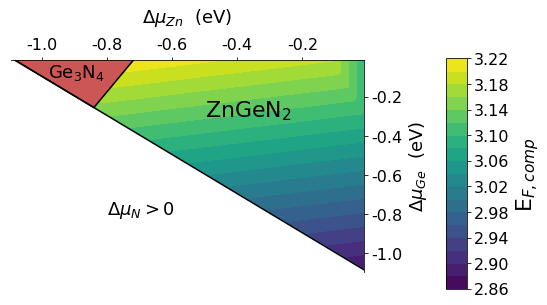

In [12]:
contourdef2(['P_Ge','Zn_Ge'],20,'intersect',charge=['1','-2'],add_mu={'O':ChemPot['O'][0]/2-4.0})
#contourdef('O_N',40,add_mu={'O':ChemPot['O'][0]/2-4.0})
#contourdef('O_N',40)

-2.3719226
-6.450436785000001
-9.670895155
{'V_Zn': {'Zn': -1, 'Ge': 0, 'N': 0}, 'P_Ge': {'P': 1, 'Zn': 0, 'Ge': -1, 'N': 0}}
3.3114946483332943


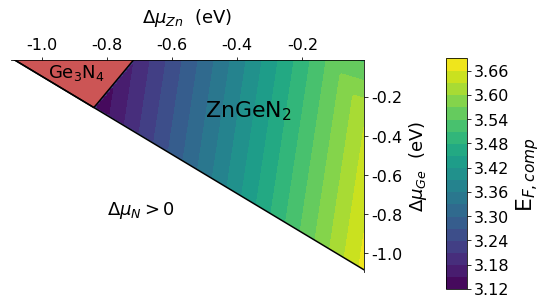

In [13]:
ax = contourdef2(['P_Ge','V_Zn'],20,'intersect',charge=['1','-2'])

plt.show()

-2.3719226
-6.450436785000001
-9.670895155
{'Li_i': {'Zn': 0, 'N': 0, 'Ge': 0, 'Li': 1}, 'Li_Zn': {'Zn': -1, 'N': 0, 'Ge': 0, 'Li': 1}}
1.466847575000028


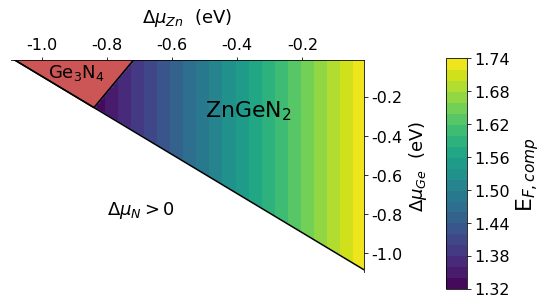

In [14]:
ax = contourdef2(['Li_i','Li_Zn'],20,'intersect',charge=['1','-1'])

plt.show()

In [15]:
FormEnth('InN')

0.15827260749999894

In [16]:
ChemPot

{'Al': [-16.41683292, {'Al': 4}],
 'AlN': [-34.96263378, {'Al': 2, 'N': 2}],
 'As': [-33.75142116, {'As': 6}],
 'C': [-84.37207806, {'C': 8}],
 'Ca': [-3.61254745, {'Ca': 2}],
 'CaN': [-477.91231295, {'Ca': 48, 'N': 32}],
 'Cu': [-14.56107699, {'Cu': 4}],
 'Ga': [-27.06451165, {'Ga': 8}],
 'GaN': [-29.6145308, {'Ga': 2, 'N': 2}],
 'Ge': [-10.70087357, {'Ge': 2}],
 'Ge3N4': [-230.84178365, {'Ge': 12, 'N': 16}],
 'GeAs': [-133.266014, {'As': 12, 'Ge': 12}],
 'GeO2': [-72.90652552, {'Ge': 3, 'O': 6}],
 'GeS2': [-271.8334294, {'Ge': 16, 'S': 32}],
 'H': [-7.82474526, {'H': 2}],
 'In': [-11.69994163, {'In': 4}],
 'InN': [-25.98035876, {'In': 2, 'N': 2}],
 'Li': [-3.89574138, {'Li': 2}],
 'Li3N': [-17.72148574, {'Li': 3, 'N': 1}],
 'LiN3': [-66.13528866, {'Li': 2, 'N': 6}],
 'Mg': [-3.08794758, {'Mg': 2}],
 'N': [-20.44693316, {'N': 2}],
 'O': [-14.02604683, {'O': 2}],
 'P': [-51.69489998, {'P': 8}],
 'P3N5': [-297.47323234, {'N': 20, 'P': 12}],
 'S': [-41.96811057, {'S': 8}],
 'Sc': [-14.99

In [17]:
ChemPot['In'][0]=-11.64717510

{'Ga_Zn 0/1': 3.709}
('$\\rm Ga_{Zn}$', 0.3856605500000363)
{'Ge_Zn -1/0': 4.158, 'Ge_Zn 3/4': -1.154, 'Ge_Zn 2/3': -0.74, 'Ge_Zn 1/2': 3.073, 'Ge_Zn -2/-1': 4.41, 'Ge_Zn 0/1': 2.9, 'Ge_Zn -3/-2': 5.057}
('$\\rm Ge_{Zn}$', 1.8884858949999854)
{'V_Zn -1/0': 0.918, 'V_Zn 1/2': -0.11, 'V_Zn -2/-1': 1.439, 'V_Zn 0/1': 0.613}
('$V_{\\rm Zn}$', 4.892805660000036)
{'O_N 1/2': -0.542, 'O_N 0/1': 3.657, 'O_N -1/0': 3.93}
('$\\rm O_N$', 0.7109041400000269)
{'H_i -1/0': 2.081, 'H_i 0/1': 4.172}
('H$_i$', 0.3480492600000584)


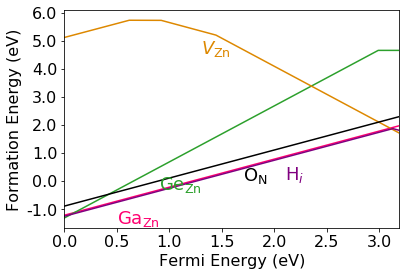

In [18]:
PlotForm(['Ga_Zn', 'Ge_Zn', 'V_Zn', 'O_N', 'H_i'],Gepoor)

{'As_Ge -1/0': 3.96, 'As_Ge 0/1': 3.699}
('$\\rm As_{Ge}$', 1.0651434066667296)


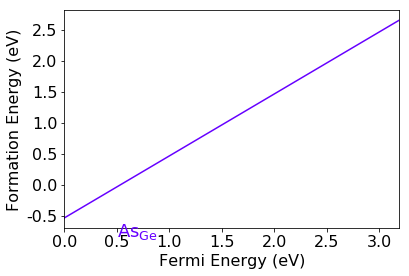

In [19]:
PlotForm(['As_Ge'],Znpoor1)

In [20]:
ChemPot['P'][0]/8.0

-6.4618624975

{'As_Ge -1/0': 3.96, 'As_Ge 0/1': 3.699}
('$\\rm As_{Ge}$', 1.0651434066667296)
{'As_N 0/1': 0.791, 'As_N -1/0': 4.192, 'As_N 1/2': -0.048}
('$\\rm As_{N}$', 2.652898852291769)
{'As_Zn -1/0': 3.312, 'As_Zn 1/2': 1.4, 'As_Zn 0/1': 3.122, 'As_Zn 2/3': 1.53}
('$\\rm As_{Zn}$', 2.8885954404167355)
{'Zn_Ge -1/0': 0.694, 'Zn_Ge 1/2': -0.799, 'Zn_Ge -3/-2': 4.757, 'Zn_Ge 0/1': 0.111, 'Zn_Ge -2/-1': 1.412}
('$\\rm Zn_{Ge}$', 4.290649856249999)


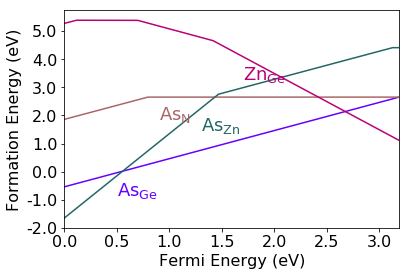

In [16]:
PlotForm(['As_Ge','As_N','As_Zn','Zn_Ge'],Znpoor1)

{'P_Ge 0/1': 3.726, 'P_Ge -1/0': 3.997}
('$\\rm P_{Ge}$', -0.5648261756249111)
{'As_Ge -1/0': 3.96, 'As_Ge 0/1': 3.699}
('$\\rm As_{Ge}$', 1.0651434066667296)
{'Zn_Ge -1/0': 0.694, 'Zn_Ge 1/2': -0.799, 'Zn_Ge -3/-2': 4.757, 'Zn_Ge 0/1': 0.111, 'Zn_Ge -2/-1': 1.412}
('$\\rm Zn_{Ge}$', 4.290649856249999)


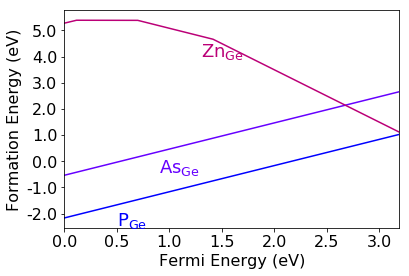

In [17]:
PlotForm(['P_Ge','As_Ge','Zn_Ge'],Znpoor1)

{}
{}


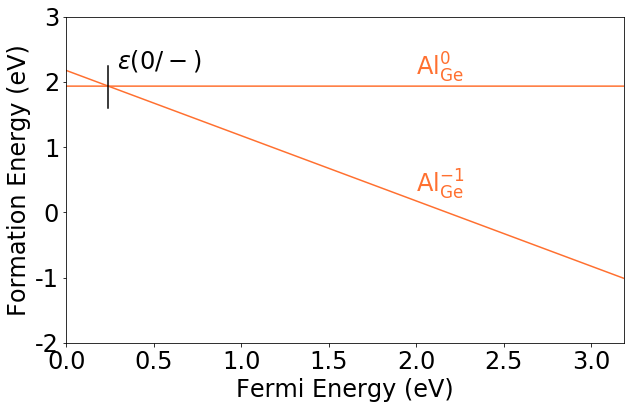

In [22]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)


Ef=np.arange(0, bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB'],0.0001)
Al_Ge0 = getLine('Al_Ge', Gepoor, charge='0')
Al_Gen1 = getLine('Al_Ge', Gepoor, charge='-1')
E01 = np.argmin(abs(Al_Gen1-Al_Ge0))/1.0e4

plt.plot(Ef, Al_Ge0, color=colors['Al_Ge'])
plt.plot(Ef, Al_Gen1, color=colors['Al_Ge'])
plt.plot([E01, E01],[1.6,2.25],'-', color='black')
plt.ylim(-2,3)
plt.xlim(0,bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB'])

ax.text(0.05+E01,2.2,r'$\epsilon(0/-)$',fontdict={'size':24},color='black')

ax.text(2,2.1,r'$\rm Al_{Ge}^0$',fontdict={'size':24},color=colors['Al_Ge'])
ax.text(2,0.3,r'$\rm Al_{Ge}^{-1}$',fontdict={'size':24},color=colors['Al_Ge'])

plt.ylabel('Formation Energy (eV)', fontsize=24)

plt.xlabel('Fermi Energy (eV)', fontsize=24)


ax.set_xticklabels(ax.get_xticks(), fontsize=24)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=24)

plt.savefig('Al_GeAcceptorLevel.png', bbox_inches='tight', format='png', dpi=300)



{'Al_Ge -1/0': 0.241}
{'Al_Zn 0/1': 3.733}


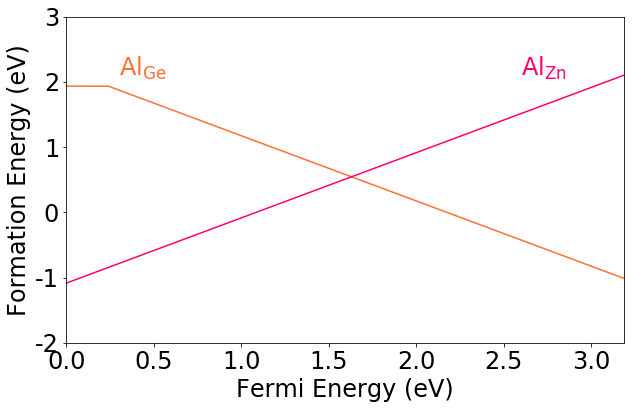

In [23]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)


Ef=np.arange(0, bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB'],0.0001)
Al_Ge = getLine('Al_Ge', Gepoor)
Al_Zn = getLine('Al_Zn', Gepoor)
#E01 = np.argmin(abs(Al_Gen1-Al_Ge0))/1.0e4

plt.plot(Ef, Al_Ge, color=colors['Al_Ge'])
plt.plot(Ef, Al_Zn, color=colors['Al_Zn'])
plt.ylim(-2,3)
plt.xlim(0,bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB'])

ax.text(0.3,2.1,r'$\rm Al_{Ge}$',fontdict={'size':24},color=colors['Al_Ge'])
ax.text(2.6,2.1,r'$\rm Al_{Zn}$',fontdict={'size':24},color=colors['Al_Zn'])


plt.ylabel('Formation Energy (eV)', fontsize=24)

plt.xlabel('Fermi Energy (eV)', fontsize=24)



ax.set_xticklabels(ax.get_xticks(), fontsize=24)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=24)

plt.savefig('Al_compAPS.png', bbox_inches='tight', format='png', dpi=300)



{'Al_Ge -1/0': 0.241}
{'Al_Zn 0/1': 3.733}
{'H_i -1/0': 2.081, 'H_i 0/1': 4.172}


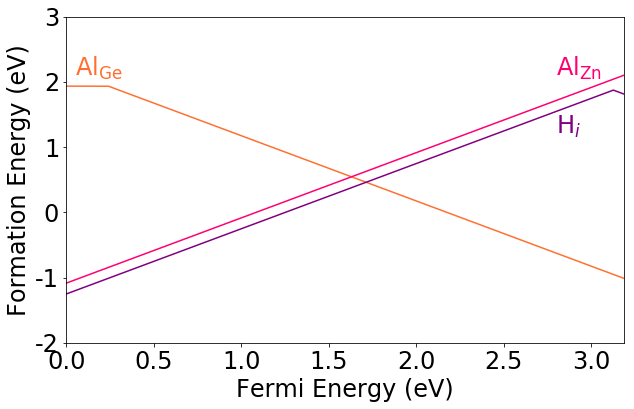

In [24]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)


Ef=np.arange(0, bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB'],0.0001)
Al_Ge = getLine('Al_Ge', Gepoor)
Al_Zn = getLine('Al_Zn', Gepoor)
H_i = getLine('H_i', Gepoor)
#E01 = np.argmin(abs(Al_Gen1-Al_Ge0))/1.0e4

plt.plot(Ef, Al_Ge, color=colors['Al_Ge'])
plt.plot(Ef, Al_Zn, color=colors['Al_Zn'])
plt.plot(Ef, H_i, color=colors['H_i'])

plt.ylim(-2,3)
plt.xlim(0,bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB'])

ax.text(0.05,2.1,r'$\rm Al_{Ge}$',fontdict={'size':24},color=colors['Al_Ge'])
ax.text(2.8,2.1,r'$\rm Al_{Zn}$',fontdict={'size':24},color=colors['Al_Zn'])
ax.text(2.8,1.2,r'H$_i$',fontdict={'size':24},color=colors['H_i'])




plt.ylabel('Formation Energy (eV)', fontsize=24)

plt.xlabel('Fermi Energy (eV)', fontsize=24)


ax.set_xticklabels(ax.get_xticks(), fontsize=24)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=24)

plt.savefig('Al_compAPS2build.png', bbox_inches='tight', format='png', dpi=300)



{'Al_Ge -1/0': 0.241}
{'Al_Zn 0/1': 3.733}
{'H_i -1/0': 2.081, 'H_i 0/1': 4.172}
{'AlPair -1/0': 4.051, 'AlPair 0/1': -0.126}
{'Al_Ge-H -1/0': 4.665, 'Al_Ge-H 0/1': -0.229}


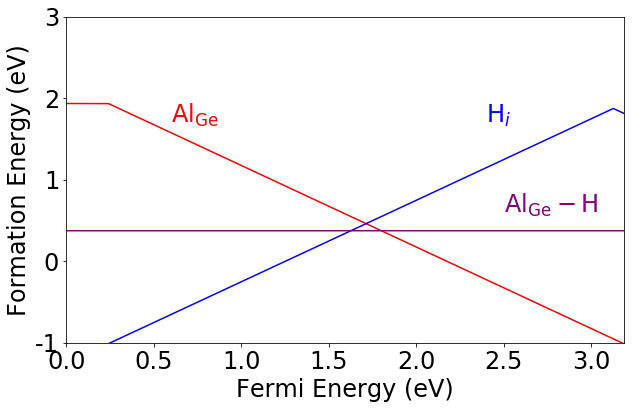

In [25]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)


Ef=np.arange(0, bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB'],0.0001)
Al_Ge = getLine('Al_Ge', Gepoor)
Al_Zn = getLine('Al_Zn', Gepoor)
H_i = getLine('H_i', Gepoor)
AlPair = getLine('AlPair', Gepoor)
AlH = getLine('Al_Ge-H', Gepoor)
#E01 = np.argmin(abs(Al_Gen1-Al_Ge0))/1.0e4

plt.plot(Ef, Al_Ge, color='red')
plt.plot(Ef, H_i, color='blue')
plt.plot(Ef, AlH, color='purple')

plt.ylim(-1,3)
plt.xlim(0,bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB'])

ax.text(0.6,1.7,r'$\rm Al_{Ge}$',fontdict={'size':24},color='red')
ax.text(2.4,1.7,r'H$_i$',fontdict={'size':24},color='blue')
ax.text(2.5,0.6,r'$\rm Al_{Ge}-H$',fontdict={'size':24},color='purple')



plt.ylabel('Formation Energy (eV)', fontsize=24)

plt.xlabel('Fermi Energy (eV)', fontsize=24)


ax.set_xticklabels(ax.get_xticks(), fontsize=24)
ax.set_yticks([-1, 0, 1, 2,3])
ax.set_yticklabels(ax.get_yticks(), fontsize=24)

plt.savefig('Al_compAPS2.png', bbox_inches='tight', format='png', dpi=300)



{'Al_Ge -1/0': 0.241}
{'Al_Zn 0/1': 3.733}
{'H_i -1/0': 2.081, 'H_i 0/1': 4.172}
{'AlPair -1/0': 4.051, 'AlPair 0/1': -0.126}
{'Al_Ge-H -1/0': 4.665, 'Al_Ge-H 0/1': -0.229}


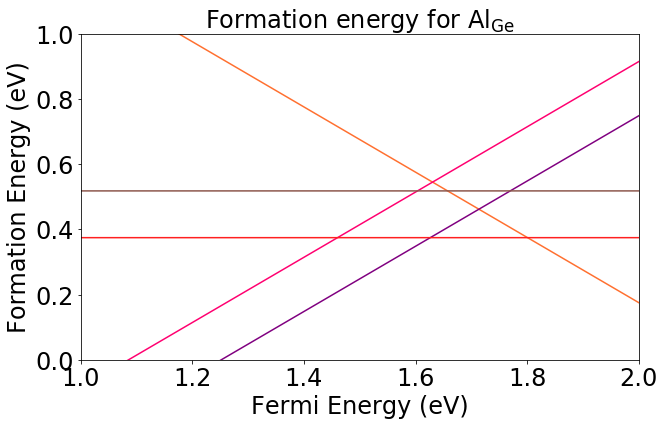

In [26]:
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)


Ef=np.arange(0, bEdges['ZnGeN2_CB']-bEdges['ZnGeN2_VB'],0.0001)
Al_Ge = getLine('Al_Ge', Gepoor)
Al_Zn = getLine('Al_Zn', Gepoor)
H_i = getLine('H_i', Gepoor)
AlPair = getLine('AlPair', Gepoor)
AlH = getLine('Al_Ge-H', Gepoor)
#E01 = np.argmin(abs(Al_Gen1-Al_Ge0))/1.0e4

plt.plot(Ef, Al_Ge, color=colors['Al_Ge'])
plt.plot(Ef, Al_Zn, color=colors['Al_Zn'])
plt.plot(Ef, H_i, color=colors['H_i'])
plt.plot(Ef, AlPair, color=colors['AlPair'])
plt.plot(Ef, AlH, color=colors['Al_Ge-H'])

plt.ylim(0,1)
plt.xlim(1,2)

#ax.text(0.05,2.1,r'$\rm Al_{Ge}$',fontdict={'size':24},color=colors['Al_Ge'])
#ax.text(2.8,2.1,r'$\rm Al_{Zn}$',fontdict={'size':24},color=colors['Al_Zn'])
#ax.text(2.8,1.2,r'H$_i$',fontdict={'size':24},color=colors['H_i'])
#ax.text(0.05,-0.0,r'$\rm Al_{Ge}-H$',fontdict={'size':24},color=colors['Al_Ge-H'])
#ax.text(0.05,0.7,r'$\rm Al_{Ge}-Al_{Ge}$',fontdict={'size':24},color=colors['AlPair'])


plt.ylabel('Formation Energy (eV)', fontsize=24)

plt.xlabel('Fermi Energy (eV)', fontsize=24)

plt.title(r'Formation energy for $\rm Al_{Ge}$', fontsize=24)


ax.set_xticklabels(ax.get_xticks(), fontsize=24)
ax.set_yticklabels(ax.get_yticks(), fontsize=24)

plt.savefig('Al_compAPS3.png', bbox_inches='tight', format='png', dpi=300)



In [27]:
A = getLine('Li_Zn', Znpoor1)
B = getLine('Li_i', Znpoor1)
[np.argmin(abs(A-B))]

{'Li_Zn -1/0': 0.362}
{'Li_i -1/0': 4.051, 'Li_i 0/1': 3.777}


[13857]

In [28]:
P_Ge = getLine('P_Ge',Znpoor1)

{'P_Ge 0/1': 3.726, 'P_Ge -1/0': 3.997}


In [29]:
P_Ge

array([-2.16482618, -2.16472618, -2.16462618, ...,  1.02407382,
        1.02417382,  1.02427382])

In [30]:
A = getLine('In_Ge', Gepoor)
B = getLine('H_i', Gepoor)
[np.argmin(abs(A-B))]

{'In_Ge -1/0': 0.457}
{'H_i -1/0': 2.081, 'H_i 0/1': 4.172}


[22023]

In [31]:
P_Ge = getLine('P_Ge', Znpoor1)
V_Zn = getLine('V_Zn',Znpoor1)
Zn_Ge = getLine('Zn_Ge',Znpoor1)

{'P_Ge 0/1': 3.726, 'P_Ge -1/0': 3.997}
{'V_Zn -1/0': 0.918, 'V_Zn 1/2': -0.11, 'V_Zn -2/-1': 1.439, 'V_Zn 0/1': 0.613}
{'Zn_Ge -1/0': 0.694, 'Zn_Ge 1/2': -0.799, 'Zn_Ge -3/-2': 4.757, 'Zn_Ge 0/1': 0.111, 'Zn_Ge -2/-1': 1.412}


In [32]:
A = getLine('LiPair', Gepoor)
B = getLine('Li_i', Gepoor)
C = getLine('Li_Zn', Gepoor)
D = B+C-A
print(A[10000], B[10000], C[10000])
print(D[10000])

{'LiPair 0/1': -0.227, 'LiPair -1/0': 4.094}
{'Li_i -1/0': 4.051, 'Li_i 0/1': 3.777}
{'Li_Zn -1/0': 0.362}
(0.26105553000001347, -0.1178683699999854, 1.3658267800001154)
0.98690288


In [33]:
A = getLine('Li_Zn-H', Gepoor)
B = getLine('Li_Zn', Gepoor)
C = getLine('H_i', Gepoor)
D = B+C-A
print(A[10000], B[10000], C[10000])
print(D[10000])

{'Li_Zn-H -1/0': 4.1, 'Li_Zn-H 0/1': -0.208}
{'Li_Zn -1/0': 0.362}
{'H_i -1/0': 2.081, 'H_i 0/1': 4.172}
(0.029564490000007382, 1.3658267800001154, -0.25195073999994211)
1.08431155


In [34]:
A = getLine('InPair', Gepoor)
B = getLine('In_Ge', Gepoor)
C = getLine('In_Zn', Gepoor)
D = B+C-A
print(A[10000], B[10000], C[10000])
print(D[10000])

{}
{'In_Ge -1/0': 0.457}
{'In_Zn 0/1': 3.672}
(1.6654395950000307, 2.1527145599999757, 0.015459225000010957)
0.50273419


In [35]:
A = getLine('GaPair', Gepoor)
B = getLine('Ga_Ge', Gepoor)
C = getLine('Ga_Zn', Gepoor)
D = B+C-A
print(A[10000], B[10000], C[10000])
print(D[10000])

{'GaPair -1/0': 4.035, 'GaPair 0/1': -0.043}
{'Ga_Ge -1/0': 0.301}
{'Ga_Zn 0/1': 3.709}
(0.50604987500001197, 1.3029873150000437, -0.21433944999996424)
0.58259799


In [36]:
A = getLine('Ga_Ge-H', Gepoor)
B = getLine('Ga_Ge', Gepoor)
C = getLine('H_i', Gepoor)
D = B+C-A
print(A[10000], B[10000], C[10000])
print(D[10000])

{'Ga_Ge-H -1/0': 4.112, 'Ga_Ge-H 0/1': -0.105}
{'Ga_Ge -1/0': 0.301}
{'H_i -1/0': 2.081, 'H_i 0/1': 4.172}
(0.47336781500005021, 1.3029873150000437, -0.25195073999994211)
0.57766876


In [37]:
64 / (10.4036877597000004e-8 * 10.9434446273999999e-8 * 12.9063964290000008e-8) * np.exp(-1.3180728047916954 / (0.0257 * (775.0+298.0)/298.0))

28383980719890804.0

{'P_Ge 0/1': 3.726, 'P_Ge -1/0': 3.997}
('$\\rm P_{Ge}$', -0.89428413999990841)
{'As_Ge -1/0': 3.96, 'As_Ge 0/1': 3.699}
('$\\rm As_{Ge}$', 1.3990463187500621)
{'O_N 1/2': -0.542, 'O_N 0/1': 3.657, 'O_N -1/0': 3.93}
('$\\rm O_N$', 0.16347556500002725)
{'S_N -1/0': 4.089, 'S_N 0/1': 3.829}
('$\\rm S_N$', 1.6949025575000967)
{'Se_N 0/1': 3.842, 'Se_N -1/0': 4.107}
('$\\rm Se_N$', 2.530967899999979)


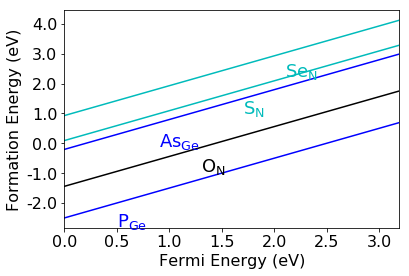

In [38]:
PlotForm(['P_Ge', 'As_Ge', 'O_N', 'S_N', 'Se_N'],Npoor)

{'In_Zn 0/1': 3.672}
('$\\rm In_{Zn}$', 0.61545922500001149)
{'In_Ge -1/0': 0.457}
('$\\rm In_{Ge}$', 2.6475717099999745)
{'Zn_Ge -1/0': 0.694, 'Zn_Ge 1/2': -0.799, 'Zn_Ge -3/-2': 4.757, 'Zn_Ge 0/1': 0.111, 'Zn_Ge -2/-1': 1.412}
('$\\rm Zn_{Ge}$', 3.5784273249999998)
{'V_Zn -1/0': 0.918, 'V_Zn 1/2': -0.11, 'V_Zn -2/-1': 1.439, 'V_Zn 0/1': 0.613}
('$V_{\\rm Zn}$', 4.892805660000036)


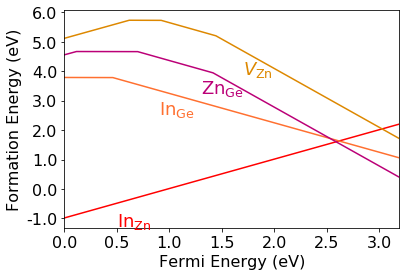

In [39]:
PlotForm(['In_Zn','In_Ge', 'Zn_Ge', 'V_Zn'],Npoor)

In [40]:
y,x = 109,97
a = -1.1 + x/100.0
b = -1.1 + y/100.0
c = -0.547428575 -(a+b)/2.0

V_Zn = getLine('V_Zn', [a,b,c])
Zn_Ge = getLine('Zn_Ge', [a,b,c])
O_N = getLine('O_N', [a,b,c])

V_Zn = getLine('V_Zn', [-0.5, -0.5, -0.045])
Zn_Ge = getLine('Zn_Ge', [-0.5, -0.5, -0.045])
As_Ge = getLine('As_Ge', [-0.5, -0.5, -0.045])

[a, b, c]


{'V_Zn -1/0': 0.918, 'V_Zn 1/2': -0.11, 'V_Zn -2/-1': 1.439, 'V_Zn 0/1': 0.613}
{'Zn_Ge -1/0': 0.694, 'Zn_Ge 1/2': -0.799, 'Zn_Ge -3/-2': 4.757, 'Zn_Ge 0/1': 0.111, 'Zn_Ge -2/-1': 1.412}
{'O_N 1/2': -0.542, 'O_N 0/1': 3.657, 'O_N -1/0': 3.93}
{'V_Zn -1/0': 0.918, 'V_Zn 1/2': -0.11, 'V_Zn -2/-1': 1.439, 'V_Zn 0/1': 0.613}
{'Zn_Ge -1/0': 0.694, 'Zn_Ge 1/2': -0.799, 'Zn_Ge -3/-2': 4.757, 'Zn_Ge 0/1': 0.111, 'Zn_Ge -2/-1': 1.412}
{'As_Ge -1/0': 3.96, 'As_Ge 0/1': 3.699}


[-0.13000000000000012, -0.010000000000000009, -0.4774285749999999]

{'As_N 0/1': 0.791, 'As_N -1/0': 4.192, 'As_N 1/2': -0.048}
('$\\rm As_{N}$', 2.6306904987501021)


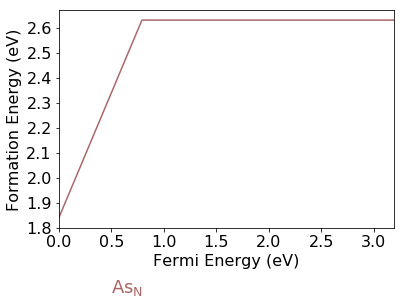

In [43]:
PlotForm(['As_N'],Npoor)

In [38]:
DefTot['P_N'][0]

{'-1': -888.81771925,
 '0': -895.67536732,
 '1': -899.1583451,
 '2': -902.23599712}

In [42]:
ef = 24907
#Npoor: 30670
#Znpoor1: 29907
#Znpoor2: 28946
#Gepoor: 28549
T = 1000.0
me = 0.21442691171479733 * 9.10938e-31
kb = 1.38064852e-23
h = 6.62607004e-34
q = 1.6e-19
Nc = lambda T: 2 * ((2*np.pi*me*kb*T)/h**2)**(3.0/2.0)/1.0e6
V = 4 / (5.47e-8 * 6.45e-8 * 5.2e-8)


B = V * np.exp(-(As_Ge[ef])*q/kb/T)
C = -2*V * np.exp(-(V_Zn[ef])*q/kb/T)
D = -2*V * np.exp(-(Zn_Ge[ef])*q/kb/T)

Elec = Nc(T) *np.exp((ef-31891)/10000.0/8.61733e-5/T)

[B + C + D-Elec, Elec/1e14]

[185648960482.0, 45.816950170873518]

In [43]:
DefTot

{'AlPair': [{'-1': -900.76799367, '0': -907.56652313, '1': -910.47125542},
  {'Al': 2, 'Ge': 31, 'N': 64, 'Zn': 31}],
 'Al_Ge': [{'-1': -897.3254069, '0': -900.16366061},
  {'Al': 1, 'Ge': 31, 'N': 64, 'Zn': 32}],
 'Al_Ge-H': [{'-1': -898.3837603, '0': -905.63633284, '1': -908.38812341},
  {'Al': 1, 'Ge': 31, 'H': 1, 'N': 64, 'Zn': 32}],
 'Al_Zn': [{'0': -904.62426901, '1': -911.39871314},
  {'Al': 1, 'Ge': 32, 'N': 64, 'Zn': 31}],
 'Al_i': [{'0': -897.93175756,
   '1': -904.84963109,
   '2': -911.21877123,
   '3': -917.78909189},
  {'Al': 1, 'Ge': 32, 'N': 64, 'Zn': 32}],
 'As_Ge': [{'-1': -891.8341766, '0': -898.52661309, '1': -905.2364975},
  {'As': 1, 'Ge': 31, 'N': 64, 'Zn': 32}],
 'As_N': [{'-1': -887.12366814, '0': -893.97325595, '1': -897.73490692},
  {'As': 1, 'Ge': 32, 'N': 63, 'Zn': 32}],
 'As_Zn': [{'-1': -894.67145705,
   '0': -900.64649732,
   '1': -906.80433712,
   '2': -911.64920084,
   '3': -916.98683613},
  {'As': 1, 'Ge': 32, 'N': 64, 'Zn': 31}],
 'Be_Ge': [{'-1': -8

In [44]:
### 4:1 17781
# 1:1 17203
# delta Al = -0.1 17659

a = 17660
b = 4 / (5.47e-8 * 6.45e-8 * 5.2e-8) * np.exp(-(Al_Ge[a]+0.1)/8.61733e-5/1050.0)
c = 4 / (5.47e-8 * 6.45e-8 * 5.2e-8) * np.exp(-(Al_Zn[a]+0.1)/8.61733e-5/1050.0)
d = 4 / (5.47e-8 * 6.45e-8 * 5.2e-8) * np.exp(-H_i[a]/8.61733e-5/1050.0)
b - c - d

51339815034208256.0

In [9]:
DefTot['S_Zn']

[{'-1': -893.32371707,
  '0': -900.11156826,
  '1': -904.75184283,
  '2': -909.04460989,
  '3': -913.6445898,
  '4': -918.13479238},
 {'Ge': 32, 'N': 64, 'S': 1, 'Zn': 31}]

In [44]:
b-c

7.4384195674778206e+19

In [45]:
a = 31530

b = 4 / (5.47e-8 * 6.45e-8 * 5.2e-8) * np.exp(-(P_Ge[a])/8.61733e-5/1050.0)
c = 8 / (5.47e-8 * 6.45e-8 * 5.2e-8) * np.exp(-(V_Zn[a])/8.61733e-5/1050.0)
d = 8 / (5.47e-8 * 6.45e-8 * 5.2e-8) * np.exp(-(Zn_Ge[a])/8.61733e-5/1050.0)

b - c - d

922121136454592.0

In [46]:
a = 30860

b = 4 / (5.47e-8 * 6.45e-8 * 5.2e-8) * np.exp(-(P_Ge[a])/8.61733e-5/1050.0)
c = 8 / (5.47e-8 * 6.45e-8 * 5.2e-8) * np.exp(-(V_Zn[a])/8.61733e-5/1050.0)
d = 8 / (5.47e-8 * 6.45e-8 * 5.2e-8) * np.exp(-(Zn_Ge[a])/8.61733e-5/1050.0)

Elec = 2.3e18 *np.exp((a-31891)/10000.0/8.61733e-5/1050.0)

bg = 4 / (5.47e-8 * 6.45e-8 * 5.2e-8) * np.exp(-(P_Ge[a])/8.61733e-5/1050.0)
cg = 8 / (5.47e-8 * 6.45e-8 * 5.2e-8) * np.exp(-(V_Zn[a])/8.61733e-5/1050.0)
dg = 8 / (5.47e-8 * 6.45e-8 * 5.2e-8) * np.exp(-(Zn_Ge[a])/8.61733e-5/1050.0)

[b - c - d-Elec, (bg -cg -dg)/bg]

[791084326892416.0, 0.89180070137250866]

{'In_Ge -1/0': 0.457}
('$\\rm In_{Ge}$', 1.5527145599999752)
{'H_i -1/0': 2.081, 'H_i 0/1': 4.172}
('H$_i$', 0.34804926000005842)
{'In_Zn 0/1': 3.672}
('$\\rm In_{Zn}$', 0.61545922500001149)


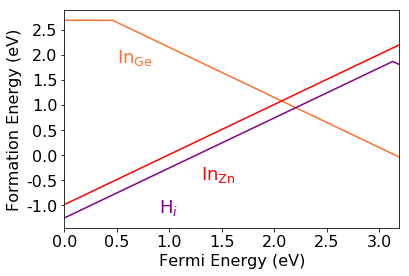

In [47]:

PlotForm(['In_Ge', 'H_i', 'In_Zn'],Gepoor)

{'Al_Ge -1/0': 0.241}
('$\\rm Al_{Ge}$', 0.5753367850000481)
{'H_i -1/0': 2.081, 'H_i 0/1': 4.172}
('H$_i$', 0.3480492600000584)
{'Al_Zn 0/1': 3.733}
('$\\rm Al_{Zn}$', 0.5142278800000337)


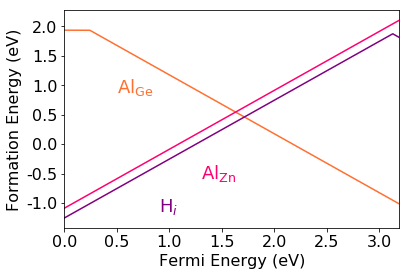

In [41]:
PlotForm(['Al_Ge', 'H_i', 'Al_Zn'],Gepoor)

{'Li_i -1/0': 4.051, 'Li_i 0/1': 3.777}
('Li$_i$', 0.4183591935416815)
{'H_i -1/0': 2.081, 'H_i 0/1': 4.172}
('H$_i$', 0.3480492600000584)
{'Li_Zn-H -1/0': 4.1, 'Li_Zn-H 0/1': -0.208}
('$\\rm Li_{Zn}-H$', -0.7464304777083264)
{'Li_Zn -1/0': 0.362}
('$\\rm Li_{Zn}$', -0.010168187708218923)
{'Ge_Zn -1/0': 4.158, 'Ge_Zn 3/4': -1.154, 'Ge_Zn 2/3': -0.74, 'Ge_Zn 1/2': 3.073, 'Ge_Zn -2/-1': 4.41, 'Ge_Zn 0/1': 2.9, 'Ge_Zn -3/-2': 5.057}
('$\\rm Ge_{Zn}$', 0.08140621374998602)
{'LiPair 0/1': -0.227, 'LiPair -1/0': 4.094}
('${\\rm Li_{Zn}}-{\\rm Li}_{i}$', -0.578711874166653)
{'Li_Ge -1/0': 1.018, 'Li_Ge -3/-2': 2.041, 'Li_Ge -2/-1': 1.653}
('$\\rm Li_{Ge}$', 5.565812048541696)


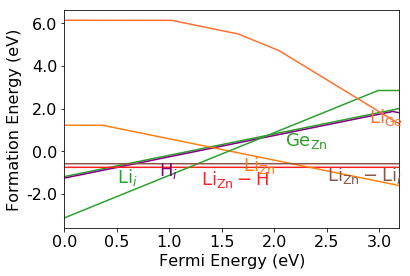

In [42]:
PlotForm(['Li_i', 'H_i', 'Li_Zn-H', 'Li_Zn', 'Ge_Zn', 'LiPair','Li_Ge'],Znpoor1)

In [43]:
0.34804926000005842+0.21435775000011503--0.52190453999999242

1.0843115500001659

{'Al_Ge -1/0': 0.241}
('$\\rm Al_{Ge}$', 0.5753367850000481)
{'Li_Zn -1/0': 0.362}
('$\\rm Li_{Zn}$', 0.7658267800001148)
{'Li_i -1/0': 4.051, 'Li_i 0/1': 3.777}
('Li$_i$', 0.48213163000001513)
{'Ge_Zn -1/0': 4.158, 'Ge_Zn 3/4': -1.154, 'Ge_Zn 2/3': -0.74, 'Ge_Zn 1/2': 3.073, 'Ge_Zn -2/-1': 4.41, 'Ge_Zn 0/1': 2.9, 'Ge_Zn -3/-2': 5.057}
('$\\rm Ge_{Zn}$', 1.8884858949999854)
{'Zn_Ge -1/0': 0.694, 'Zn_Ge 1/2': -0.799, 'Zn_Ge -3/-2': 4.757, 'Zn_Ge 0/1': 0.111, 'Zn_Ge -2/-1': 1.412}
('$\\rm Zn_{Ge}$', 2.4835701750000005)
{'Li_Zn-H -1/0': 4.1, 'Li_Zn-H 0/1': -0.208}
('$\\rm Li_{Zn}-H$', 0.029564490000007382)


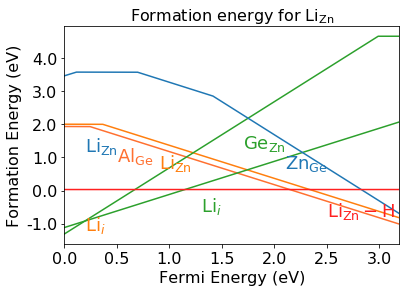

In [44]:
PlotForm(['Al_Ge','Li_Zn', 'Li_i', 'Ge_Zn', 'Zn_Ge', 'Li_Zn-H'],Gepoor)
plt.title(r'Formation energy for Li$\rm_{Zn}$',fontsize=16)
plt.text(0.2, 1.2,r'$\rmLi_{Zn}$',fontdict={'size':18},color='C0')
plt.text(0.2, -1.2,r'Li$_{i}$',fontdict={'size':18},color='C1')

plt.savefig('Li.png', bbox_inches='tight', format='png', dpi=300)


{'P_Zn 0/1': 3.066, 'P_Zn -1/0': 3.439, 'P_Zn 2/3': 2.822, 'P_Zn 1/2': 1.744}
('$\\rm P_{Zn}$', 2.0985552881251035)


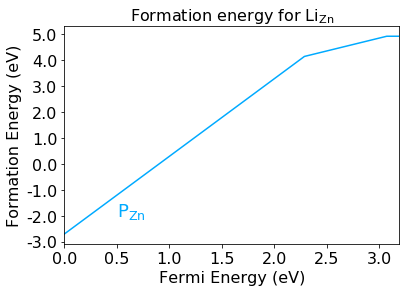

In [45]:
PlotForm(['P_Zn'],Znpoor1)
plt.title(r'Formation energy for Li$\rm_{Zn}$',fontsize=16)

plt.savefig('P_Znrich.png', bbox_inches='tight', format='png', dpi=300)

{'Se_Zn 1/2': 1.399, 'Se_Zn 2/3': 0.22, 'Se_Zn -1/0': 3.003, 'Se_Zn 3/4': -0.403, 'Se_Zn 0/1': 1.577}
('$\\rm Se_{Zn}$', 7.212822045000102)
{'Se_Ge 1/2': 1.942, 'Se_Ge -1/0': 4.121, 'Se_Ge 0/1': 2.274}
('$\\rm Se_{Ge}$', 5.146312830000087)
{'Se_N 0/1': 3.842, 'Se_N -1/0': 4.107}
('$\\rm Se_N$', 3.0783964749999786)


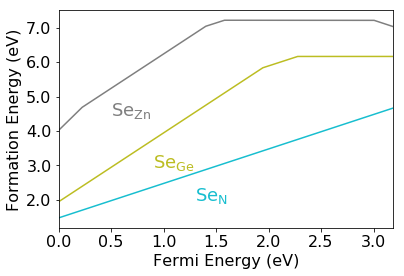

In [46]:
PlotForm(['Se_Zn', 'Se_Ge', 'Se_N'],Gepoor)


{'Se_Zn 1/2': 1.399, 'Se_Zn 2/3': 0.22, 'Se_Zn -1/0': 3.003, 'Se_Zn 3/4': -0.403, 'Se_Zn 0/1': 1.577}
('$\\rm Se_{Zn}$', 7.212822045000102)
{'Se_Ge 1/2': 1.942, 'Se_Ge -1/0': 4.121, 'Se_Ge 0/1': 2.274}
('$\\rm Se_{Ge}$', 5.146312830000087)
{'Se_N 0/1': 3.842, 'Se_N -1/0': 4.107}
('$\\rm Se_N$', 3.0783964749999786)


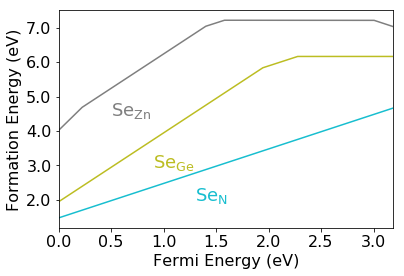

In [47]:
PlotForm(['Se_Zn', 'Se_Ge', 'Se_N'],Gepoor)


In [48]:
FormEnth('ZnGeP2')

-1.0301726524999992

In [49]:
FreyCorr

{'AlPair': {'-1': 0.0442264, '1': 0.239226},
 'Al_Ge': {'-1': 0.194226},
 'Al_Ge-H': {'-1': 0.204226, '1': 0.189226},
 'Al_Zn': {'1': 0.249226},
 'Al_i': {'1': 0.259226, '2': 0.916906, '3': 1.91304},
 'As_Ge': {'-1': 0.059226, '1': 0.219226},
 'As_N': {'-1': 0.134226, '1': 0.179226},
 'As_Zn': {'-1': 0.129226, '1': 0.244226, '2': 0.896906, '3': 1.91304},
 'C_Ge': {'-1': 0.189226, '1': 0.0992264},
 'C_N': {'-1': 0.159226, '-2': 0.666906, '1': 0.199026},
 'Cu_Zn': {'-1': 0.171226, '1': 0.219226},
 'GaPair': {'-1': 0.134226, '1': 0.119226},
 'Ga_Ge': {'-1': 0.239226},
 'Ga_Ge-H': {'-1': 0.191226, '1': 0.0692264},
 'Ga_Zn': {'1': 0.209226},
 'Ga_d_Ge': {'-1': 0.204226},
 'Ga_d_Zn': {'1': 0.243226},
 'Ga_i': {'1': 0.239226, '2': 0.836906, '3': 1.78104},
 'Ge_N': {'-1': 0.234226, '-2': 0.636906, '1': 0.124226, '2': 0.706906},
 'Ge_Zn': {'-1': 0.0992264,
  '-2': 0.466906,
  '-3': 1.27704,
  '1': 0.249226,
  '2': 0.886906,
  '3': 1.64304,
  '4': 2.74762},
 'Ge_i': {'1': 0.179226, '2': 0.770906

In [50]:
FormEnth('GaN')

-1.2007348637500002

NameError: name 'CB' is not defined

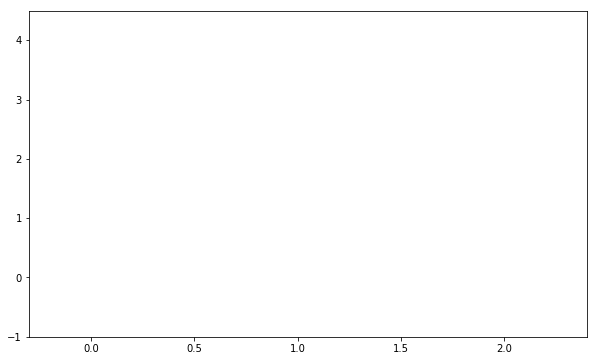

In [51]:


fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)
ax.set_xlim([-.3,2.4])
ax.set_ylim([-1,4.5])


plt.plot([0,3],[CB-VB,CB-VB],'blue')
plt.plot([0,3],[0,0],'red')
ax.axis('off')

ax.text(-0.3, -0.15 ,u'VBM',fontdict={'size':18},color='red')
ax.text(-0.3, bEdges['ZnGeN2_CB'] - bEdges['ZnGeN2_VB'] -0.15 ,u'CBM',fontdict={'size':18},color='blue')


for i in Cu_Zn_l:
    plt.plot([0.1,0.2],[i,i],'black') 
ax.text(0.09, -0.6,r'$\rmCu_{Zn}$',fontdict={'size':18},color='black')

for i in Li_Zn_l:
    plt.plot([0.4,0.5],[i,i],'black') 
ax.text(0.39, -0.6,r'$\rmLi_{Zn}$',fontdict={'size':18},color='black')

for i in Al_Ge_l:
    plt.plot([0.7,0.8],[i,i],'black') 
ax.text(0.71, -0.6,r'$\rmAl_{Ge}$',fontdict={'size':18},color='black')

for i in Al_Zn_l:
    plt.plot([1.0,1.1],[i,i],'black') 
ax.text(1.01, -0.6,r'$\rmAl_{Zn}$',fontdict={'size':18},color='black')

for i in In_Ge_l:
    plt.plot([1.3,1.4],[i,i],'black') 
ax.text(1.31, -0.6,r'$\rmIn_{Ge}$',fontdict={'size':18},color='black')

for i in In_Zn_l:
    plt.plot([1.6,1.7],[i,i],'black') 
ax.text(1.61, -0.6,r'$\rmIn_{Zn}$',fontdict={'size':18},color='black')

for i in S_N_l:
    plt.plot([1.9,2.0],[i,i],'black') 
ax.text(1.91, -0.6,r'$\rmS_{N}$',fontdict={'size':18},color='black')

for i in Se_N_l:
    plt.plot([2.2,2.3],[i,i],'black') 
ax.text(2.21, -0.6,r'$\rmSe_{N}$',fontdict={'size':18},color='black')

plt.savefig('DopantLevels.png', bbox_inches='tight', format='png', dpi=300)




In [37]:
-9.475869194166668 - -14.02604683/2

-2.462845779166668

In [56]:
setChemPot(Znpoor2)['P'] - setChemPot(Znpoor2)['N'] 

3.7616040825

-2.3719226
-6.450436785
-9.670895155
{'P': 1, 'Zn': 0, 'Ge': -1, 'N': 0}
-0.34296943125 1.08703056875


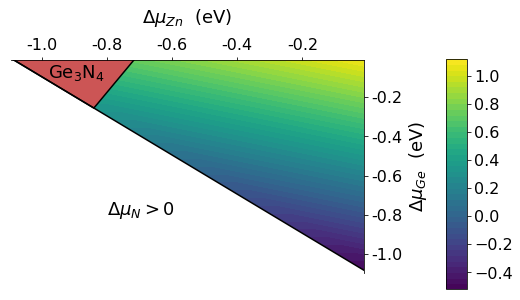

In [42]:
contourdef('P_Ge',40)

In [71]:
ChemPot['ZnGeP2'] = [0, {'Ge': 4, 'P': 8, 'Zn': 4}]

In [41]:
ChemPot = np.load('ChemicalReferences.npy').item()

In [90]:
FormEnth('ZnGeN2')

-1.0948571499999993

In [80]:
ChemPot

{'AlN': [-34.96360737, {'Al': 2, 'N': 2}],
 'C': [-84.37207806, {'C': 8}],
 'Ca': [-3.61254745, {'Ca': 2}],
 'CaN': [-477.91231295, {'Ca': 48, 'N': 32}],
 'Cu': [-14.56107699, {'Cu': 4}],
 'GaN': [-29.58753241, {'Ga': 2, 'N': 2}],
 'Ge': [-10.70087357, {'Ge': 2}],
 'Ge3N4': [-230.84178365, {'Ge': 12, 'N': 16}],
 'GeO2': [-72.90652552, {'Ge': 3, 'O': 6}],
 'GeS2': [-271.8334294, {'Ge': 16, 'S': 32}],
 'H': [-7.82474526, {'H': 2}],
 'InN': [-25.97670987, {'In': 2, 'N': 2}],
 'Li': [-3.89574138, {'Li': 2}],
 'Mg': [-3.08794758, {'Mg': 2}],
 'N': [-20.44693316, {'N': 2}],
 'O': [-14.02604683, {'O': 2}],
 'P': [-51.69489998, {'P': 8}],
 'S': [-41.96811057, {'S': 8}],
 'Se': [-13.35088177, {'Se': 3}],
 'Sn': [-36.04143642, {'Sn': 8}],
 'Zn': [-2.5438452, {'Zn': 2}],
 'Zn3N2': [-192.51659948, {'N': 16, 'Zn': 24}],
 'ZnGeN2': [-112.65659878, {'Ge': 4, 'N': 8, 'Zn': 4}],
 'ZnGeP2': [-82.30502813, {'Ge': 4, 'P': 8, 'Zn': 4}],
 'ZnO': [-22.76121164, {'O': 2, 'Zn': 2}],
 'ZnS': [-33.58395129, {'S'

In [89]:
print (setChemPot(Npoor)['P'] - -51.69489998/8.0, setChemPot(Npoor)['Ge']- -10.70087357/2.0, setChemPot(Npoor)['N']- -20.44693316/2.0)

(-0.5150863262499996, 0.0, -0.5474285749999996)


{'P_Ge 0/1': 3.726, 'P_Ge -1/0': 3.997}
('$\\rm P_{Ge}$', -0.5648261756249111)
{'Zn_Ge -1/0': 0.694, 'Zn_Ge 1/2': -0.799, 'Zn_Ge -3/-2': 4.757, 'Zn_Ge 0/1': 0.111, 'Zn_Ge -2/-1': 1.412}
('$\\rm Zn_{Ge}$', 4.290649856249999)


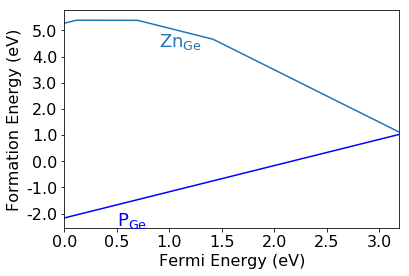

In [46]:
PlotForm(['P_Ge','Zn_Ge'],Znpoor1)

{'S_N -1/0': 4.089, 'S_N 0/1': 3.829}
('$\\rm S_N$', 2.2423311325000963)
{'Se_N 0/1': 3.842, 'Se_N -1/0': 4.107}
('$\\rm Se_N$', 3.0783964749999786)
{'P_Ge 0/1': 3.726, 'P_Ge -1/0': 3.997}
('$\\rm P_{Ge}$', -1.3408211433332431)
{'As_Ge -1/0': 3.96, 'As_Ge 0/1': 3.699}
('$\\rm As_{Ge}$', -0.15954126499993748)
{'O_N 1/2': -0.542, 'O_N 0/1': 3.657, 'O_N -1/0': 3.93}
('$\\rm O_N$', 0.71090414000002689)


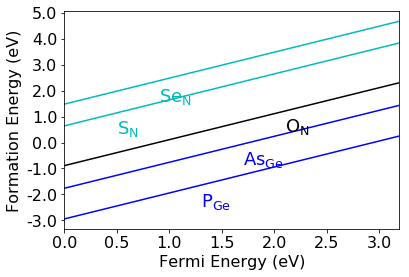

In [47]:
PlotForm(['S_N','Se_N','P_Ge','As_Ge','O_N'],Gepoor)

In [25]:
ChemPot['ZnS'][0]/4.0-ChemPot['Zn'][0]/2.0 - Znpoor1[0]

-6.411842691250001

In [28]:
(ChemPot['GeS2'][0]/16.0-ChemPot['Ge'][0]/2.0 - Znpoor1[1])/2

-5.81957627625

In [39]:
FormEnth('InN')

0.16587395750000056

-2.3719226
-6.450436785
-9.670895155
{'Zn': 0, 'N': 0, 'Ge': -1, 'In': 1}
2.8488746625 3.7988746625


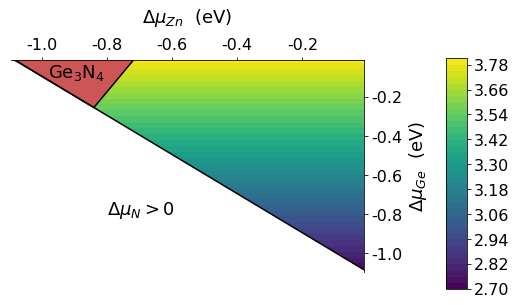

In [35]:
contourdef('In_Ge',40)

In [32]:
ChemPot['In'][0] = 0

In [34]:
ChemPot = np.load('ChemicalReferences.npy').item()

In [ ]:
contourdef2(['In_Ge','Zn_Ge'],20,'intersect',charge=['1','-2'],add_mu={'O':ChemPot['O'][0]/2-4.0})
#contourdef('O_N',40,add_mu={'O':ChemPot['O'][0]/2-4.0})
#contourdef('O_N',40)

In [19]:
DefTot['In_Ge'][0]

{'-1': -891.98197259, '0': -895.05662641}

In [118]:
3 * True

3

In [119]:
3 * False

0

In [2]:
bEdges

{'GaN25_CB': 5.245438,
 'GaN25_VB': 2.062347,
 'GaN295_CB': 5.447876,
 'GaN295_VB': 1.965016,
 'ZnGeN2_CB': 5.98107,
 'ZnGeN2_VB': 2.791913,
 'ZnSiN2_CB': 8.840683,
 'ZnSiN2_VB': 4.009651,
 'ZnSnN2_CB': 4.613189,
 'ZnSnN2_VB': 3.208647}

{'P_N -1/0': 4.185, 'P_N 0/1': 0.492, 'P_N 1/2': -0.272}
('$\\rm P_{N}$', 2.627185980000087)


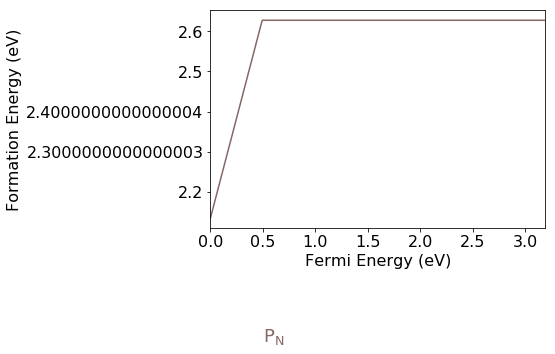

In [106]:
PlotForm(['P_N'],Znpoor1)

In [43]:
ChemPot

{'Al': [-16.41683292, {'Al': 4}],
 'AlN': [-34.96263378, {'Al': 2, 'N': 2}],
 'As': [-33.75142116, {'As': 6}],
 'C': [-84.37207806, {'C': 8}],
 'Ca': [-3.61254745, {'Ca': 2}],
 'CaN': [-477.91231295, {'Ca': 48, 'N': 32}],
 'Cu': [-14.56107699, {'Cu': 4}],
 'Ga': [-27.06451165, {'Ga': 8}],
 'GaN': [-29.6145308, {'Ga': 2, 'N': 2}],
 'Ge': [-10.70087357, {'Ge': 2}],
 'Ge3N4': [-230.84178365, {'Ge': 12, 'N': 16}],
 'GeO2': [-72.90652552, {'Ge': 3, 'O': 6}],
 'GeS2': [-271.8334294, {'Ge': 16, 'S': 32}],
 'H': [-7.82474526, {'H': 2}],
 'In': [-11.72025419, {'In': 4}],
 'InN': [-25.97531234, {'In': 2, 'N': 2}],
 'Li': [-3.89574138, {'Li': 2}],
 'Mg': [-3.08794758, {'Mg': 2}],
 'N': [-20.44693316, {'N': 2}],
 'O': [-14.02604683, {'O': 2}],
 'P': [-51.69489998, {'P': 8}],
 'P3N5': [-297.47323234, {'N': 20, 'P': 12}],
 'S': [-41.96811057, {'S': 8}],
 'Se': [-13.35088177, {'Se': 3}],
 'Sn': [-36.04143642, {'Sn': 8}],
 'Zn': [-2.5438452, {'Zn': 2}],
 'Zn3N2': [-192.51659948, {'N': 16, 'Zn': 24}],


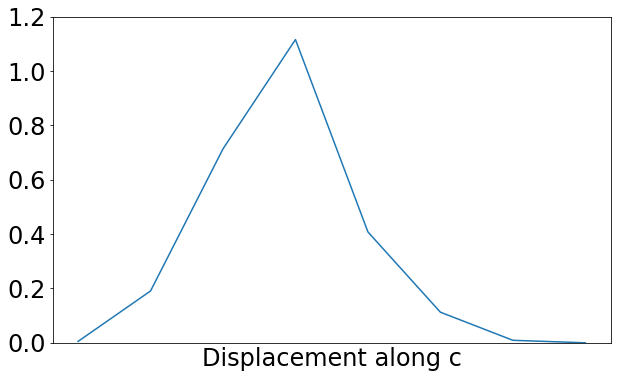

In [51]:
E = np.array([-909.37834454, -909.19280303, -908.66994116, -908.26779345, -908.9756070, -909.27086172, -909.37424612, -909.38344530])
Ediff = E-E[-1]
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)

plt.plot(Ediff)
ax.set_ylim([0, 1.2])
ax.set_yticklabels(ax.get_yticks(), fontsize=24)
ax.set_xticks([])

plt.xlabel('Displacement along c', fontsize=24)


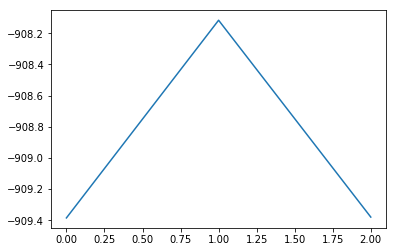

In [59]:
plt.plot([-909.38481506, -908.11698631, -909.37948845])

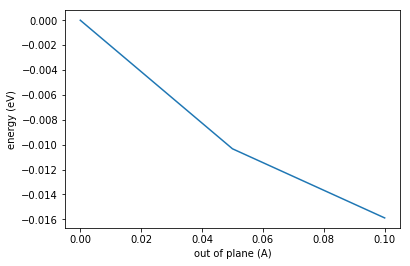

In [58]:
plt.plot([0, 0.05, 0.1],np.array([-738.15922995, -738.16956019, -738.17511464])--738.15922995)
plt.xlabel('out of plane (A)')
plt.ylabel('energy (eV)')

In [24]:
ChemPot['P3N5'][0] =-.30162542E+03

In [53]:
FormEnth('P3N5')

-3.8653876924999935

In [54]:
FormEnth('ZnGeAs2')

-0.9274608674999989

In [18]:
FreyCorr['H_i']

{'-1': 0.189226, '1': 0.149226}

In [21]:
DefTot['H_i']

[{'-1': -897.59482012, '0': -902.27821739, '1': -909.39133668},
 {'Ge': 32, 'H': 1, 'N': 64, 'Zn': 32}]

In [22]:
-909.39133668+0.149226

-909.24211068

In [25]:
-909.00059048 + 0.279226

-908.72136448

In [26]:
-909.24211068 - -908.72136448


-0.5207461999999623

In [274]:
contourdef('O_N',40)

-2.3719226
-6.450436785000001
-9.670895155


KeyError: 'Si'

In [238]:
a = 0.26
test = [-0.01, -a,a/2+0.02+ FormEnth('ZnGeN2')/2]
muZn = test[0] + ChemPot["Zn"][0]/2
muGe = test[1] + ChemPot["Ge"][0]/2
muN = test[2] + ChemPot["N"][0]/2

[muZn, muGe, muN]


[-1.2819226, -5.610436785, -10.620895155]

In [239]:
[((ChemPot['P3N5'][0]/4.0)-5*muN)/3.0, ChemPot['P'][0]/8.0, (ChemPot['ZnGeP2'][0]/4.0 - muZn - muGe)/2.0, (ChemPot['Zn3P2'][0]/8.0 - 3.0*muZn) /2.0]

[-7.087944103333332, -6.4618624975, -6.841948823749998, -7.087004915]

In [241]:
[(ChemPot['ZnS'][0]/4)-muZn, (ChemPot['GeS2'][0]/16)-muGe] 

[-7.114065222500001, -11.379152552499999]

In [289]:
FormEnth('Zn3P2')

-1.2802848349999998

In [75]:
(ChemPot['ZnGeP2'][0]/4 - muZn - muGe)/2

-6.97694882375

In [106]:
(ChemPot['Zn3P2'][0]/8 - 3*muZn) /2

-7.102004915

In [9]:

ChemPot

{'Al': [-16.41683292, {'Al': 4}],
 'AlN': [-34.96263378, {'Al': 2, 'N': 2}],
 'As': [-33.75142116, {'As': 6}],
 'C': [-84.37207806, {'C': 8}],
 'Ca': [-3.61254745, {'Ca': 2}],
 'CaN': [-477.91231295, {'Ca': 48, 'N': 32}],
 'Cu': [-14.56107699, {'Cu': 4}],
 'Ga': [-27.06451165, {'Ga': 8}],
 'GaN': [-29.6145308, {'Ga': 2, 'N': 2}],
 'Ge': [-10.70087357, {'Ge': 2}],
 'Ge3N4': [-230.84178365, {'Ge': 12, 'N': 16}],
 'GeO2': [-72.90652552, {'Ge': 3, 'O': 6}],
 'GeS2': [-271.8334294, {'Ge': 16, 'S': 32}],
 'H': [-7.82474526, {'H': 2}],
 'In': [-11.69994163, {'In': 4}],
 'InN': [-25.98035876, {'In': 2, 'N': 2}],
 'Li': [-3.89574138, {'Li': 2}],
 'Li3N': [-17.72148574, {'Li': 3, 'N': 1}],
 'LiN3': [-66.13528866, {'Li': 2, 'N': 6}],
 'Mg': [-3.08794758, {'Mg': 2}],
 'N': [-20.44693316, {'N': 2}],
 'O': [-14.02604683, {'O': 2}],
 'P': [-51.69489998, {'P': 8}],
 'P3N5': [-297.47323234, {'N': 20, 'P': 12}],
 'S': [-41.96811057, {'S': 8}],
 'Se': [-13.35088177, {'Se': 3}],
 'Si': [-50.34043737, {'Si

In [76]:
FormEnth('ZnGeP2') #-0.515

-1.0301726524999992

In [5]:
(-897.59482012 - -909.39133668)/2 - bEdges['ZnGeN2_VB']

3.106345279999993

In [3]:
ChemPot['Zn']

[-2.5438452, {'Zn': 2}]

In [109]:
ChemPot

{'Al': [-16.41683292, {'Al': 4}],
 'AlN': [-34.96263378, {'Al': 2, 'N': 2}],
 'As': [-33.75142116, {'As': 6}],
 'C': [-84.37207806, {'C': 8}],
 'Ca': [-3.61254745, {'Ca': 2}],
 'CaN': [-477.91231295, {'Ca': 48, 'N': 32}],
 'Cu': [-14.56107699, {'Cu': 4}],
 'Ga': [-27.06451165, {'Ga': 8}],
 'GaN': [-29.6145308, {'Ga': 2, 'N': 2}],
 'Ge': [-10.70087357, {'Ge': 2}],
 'Ge3N4': [-230.84178365, {'Ge': 12, 'N': 16}],
 'GeAs': [-133.266014, {'As': 12, 'Ge': 12}],
 'GeO2': [-72.90652552, {'Ge': 3, 'O': 6}],
 'GeS2': [-271.8334294, {'Ge': 16, 'S': 32}],
 'H': [-7.82474526, {'H': 2}],
 'In': [-11.69994163, {'In': 4}],
 'InN': [-25.98035876, {'In': 2, 'N': 2}],
 'Li': [-3.89574138, {'Li': 2}],
 'Li3N': [-17.72148574, {'Li': 3, 'N': 1}],
 'LiN3': [-66.13528866, {'Li': 2, 'N': 6}],
 'Mg': [-3.08794758, {'Mg': 2}],
 'N': [-20.44693316, {'N': 2}],
 'O': [-14.02604683, {'O': 2}],
 'P': [-51.69489998, {'P': 8}],
 'P3N5': [-297.47323234, {'N': 20, 'P': 12}],
 'S': [-41.96811057, {'S': 8}],
 'Sc': [-14.99

In [113]:
Znpoor1

[-0.7122225312499992, 0, -0.19131730937500002]

In [119]:
cond = [-0.67, 0, -0.21]

print -5.62523686
print (-75.20117589 / 4 - (-2.5438452/2 + cond[0] + -10.70087357/2+cond[1]))/2
print (-130.90751686 / 8 - (-2.5438452/2 * 3 + cond[0]*3))/2
print (-133.266014 / 12 - (-10.70087357/2 + cond[1]))

-5.62523686
-5.75396729375
-5.26883590375
-5.75506438167


In [97]:
cond = [-0.2, 0, -0.45]



-5.9738359037499995

In [71]:
(-130.891/8  - -2.5438452/2*3 - -5.62523686*2)

-1.2951334799999987

In [122]:
FormEnth('GeS2')

-1.1471249099999987

In [62]:
FormEnth('ZnGeAs2')

-0.9274608674999989

In [67]:
(-75.20117589/4 - -2.5438452/2 - -10.70087357/2 - 2*-5.62523686)

-0.9274608675000007

In [72]:
(-130.90751686  - -2.5438452/2*24 - -5.62523686*16)/8

-1.2971980874999982

In [85]:
(-147.15822104  - -2.5438452/2*24 - -51.69489998 * 2)/8

-1.6552848349999998

{'As_Ge -1/0': 3.96, 'As_Ge 0/1': 3.699}
('$\\rm As_{Ge}$', 1.0429350531250625)


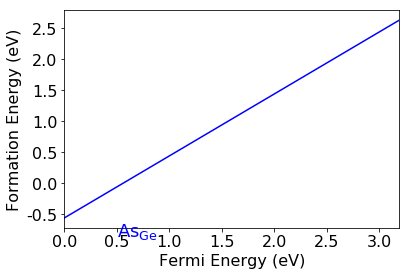

In [107]:
PlotForm(['As_Ge'],Znpoor1)